IndexError: tuple index out of range

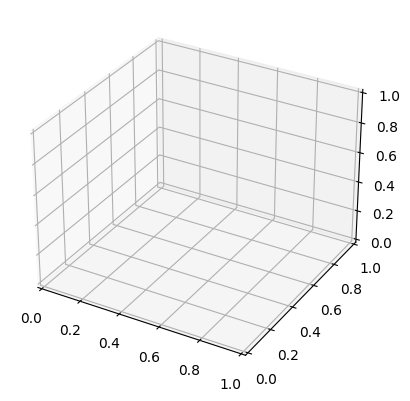

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deap import base, creator, tools, algorithms

# Step 1: 定义问题
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0, 1.0))  # 最大化
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)  # 每个变量的范围为[0, 1]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# 定义目标函数
def evaluate(individual):
    x, y, z = individual
    return x ** 2, y ** 2, z ** 2  # 三个目标函数，分别是x², y², z²


toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=20, indpb=0.1)
toolbox.register("select", tools.selNSGA2)


# Step 2: 运行NSGA-II算法并绘图
def plot_pareto(population, gen, ax):
    fitnesses = np.array([ind.fitness.values for ind in population])
    pareto_levels = tools.sortNondominated(fitnesses, len(fitnesses), first_front_only=False)[0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_levels)))
    for i, front in enumerate(pareto_levels):
        front_points = fitnesses[front]
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], label=f"Front {i}", color=colors[i])


def main():
    population = toolbox.population(n=100)
    NGEN = 50
    CXPB, MUTPB = 0.7, 0.2
    population = toolbox.select(population, 100)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()  # 开启交互模式

    for gen in range(NGEN):
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        population = tools.selNSGA2(offspring + population, len(population))

        # 清除并绘制当前一代的 Pareto-front
        ax.clear()
        plot_pareto(population, gen, ax)
        ax.set_title(f"Generation {gen}")
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.set_zlabel("Objective 3")
        plt.legend()
        plt.pause(0.1)

    plt.ioff()  # 关闭交互模式
    plt.show()


if __name__ == "__main__":
    main()


In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from deap import base, creator, tools, algorithms

# Step 1: 定义问题
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0, 1.0))  # 最大化
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)  # 每个变量的范围为[0, 1]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initPopulation, list, toolbox.individual)

# 定义目标函数
def evaluate(individual):
    x, y, z = individual
    return x**2, y**2, z**2  # 三个目标函数，分别是x², y², z²

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=20, indpb=0.1)
toolbox.register("select", tools.selNSGA2)

# Step 2: 动画绘图函数
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 动画中的数据
population_history = []

def update(frame):
    ax.clear()
    if frame >= len(population_history):
        return
    population = population_history[frame]
    
    fitnesses = np.array([ind.fitness.values for ind in population])
    pareto_levels = tools.sortNondominated(fitnesses, len(fitnesses), first_front_only=False)[0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_levels)))
    
    for i, front in enumerate(pareto_levels):
        front_points = fitnesses[front]
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], color=colors[i], label=f"Front {i}")
    
    ax.set_title(f"Generation {frame}")
    ax.set_xlabel("Objective 1")
    ax.set_ylabel("Objective 2")
    ax.set_zlabel("Objective 3")
    ax.legend()

# Step 3: 主函数
def main():
    population = toolbox.population(n=100)
    NGEN = 50
    CXPB, MUTPB = 0.7, 0.2

    for gen in range(NGEN):
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        population[:] = tools.selNSGA2(offspring + population, len(population))
        # 保存当前代的种群
        population_history.append(population[:])

    # 使用 FuncAnimation 生成动画
    anim = FuncAnimation(fig, update, frames=len(population_history), interval=200)
    anim.save("pareto_front_animation.mp4", writer="ffmpeg", fps=5)
    plt.show()

if __name__ == "__main__":
    main()


AttributeError: module 'deap.tools' has no attribute 'initPopulation'

'sphere_points_animation.gif'

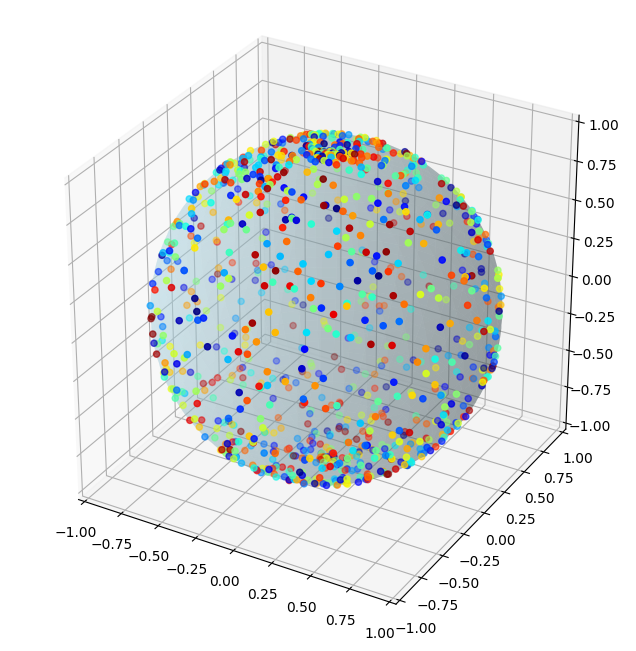

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# 初始化三维图形
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_box_aspect([1, 1, 1])  # 保持比例一致

# 绘制球面
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

# 保存点数据
points = []

# 动态更新函数
def update(frame):
    ax.clear()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_box_aspect([1, 1, 1])  # 保持比例一致
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

    # 每次添加10个点
    for _ in range(10):
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.random.uniform(0, np.pi)
        points.append((np.sin(phi) * np.cos(theta), 
                       np.sin(phi) * np.sin(theta), 
                       np.cos(phi)))
    
    # 提取点坐标
    px, py, pz = zip(*points)
    
    # 颜色根据帧数变化
    colors = plt.cm.jet(np.linspace(0, 1, len(points)))
    
    # 绘制点
    ax.scatter(px, py, pz, color=colors, s=20)

# 创建动画
ani = FuncAnimation(fig, update, frames=100, interval=100, repeat=False)
# 保存动画为 GIF
from matplotlib.animation import PillowWriter

# 设置保存路径和参数
save_path = "sphere_points_animation.gif"
writer = PillowWriter(fps=10)  # 设置帧率

# 保存动画
ani.save(save_path, writer=writer)
save_path
